# Variational Quantum Deflation

VQD is a method that extends VQE to get the first n eigenvalues.It does it by introducing a penalty function to guide the optimization process to give us the first n eigenvalues

In [556]:
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt
from qiskit import quantum_info as qi
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob,StatevectorEstimator
from qiskit.circuit.library import TwoLocal,EfficientSU2,NLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

Quantum circuit inner product calculator for the penalty function

In [557]:
import numpy as np

def inner_prod(ansatz, prev_circuits, parameters, sampler):

    def create_fidelity_circuit(circuit_1, circuit_2):

        """
        Constructs the list of fidelity circuits to be evaluated.
        These circuits represent the state overlap between pairs of input circuits,
        and their construction depends on the fidelity method implementations.
        """
                
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit
    overlaps = []

    for prev_circuit in prev_circuits:
        fidelity_circuit = create_fidelity_circuit(ansatz, prev_circuit)
        sampler_job = sampler.run([(fidelity_circuit, parameters)])
        meas_data = sampler_job.result()[0].data.meas
        
        counts_0 = meas_data.get_int_counts().get(0, 0)
        shots = meas_data.num_shots
        overlap = counts_0/shots
        overlaps.append(overlap)
    
    return np.array(overlaps)

In [558]:
def cost_func_vqd(parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian):

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])

    penalty_terms = 0

    if step > 1:
        overlaps = inner_prod(ansatz, prev_states, parameters, sampler)
        penalty_terms = np.sum([np.real(betas[state] * overlap) for state, overlap in enumerate(overlaps)])

    estimator_result = estimator_job.result()[0]

    value = estimator_result.data.evs[0] + penalty_terms

    return value

# Lets define our Ansatz

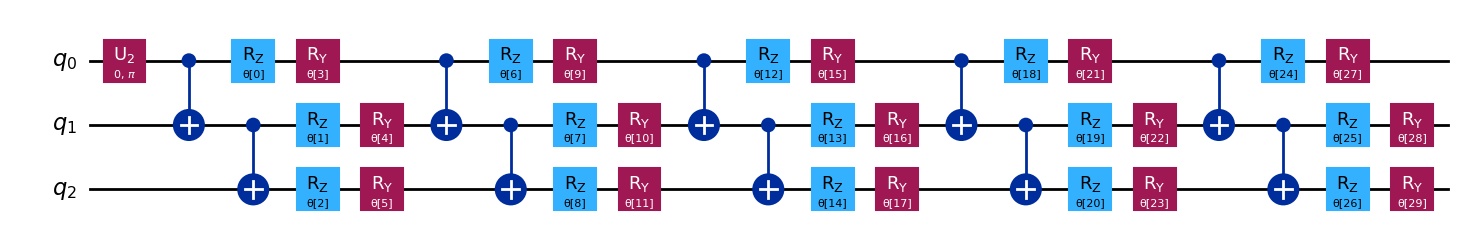

In [559]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit

import numpy as np

reference_circuit = QuantumCircuit(3)
reference_circuit.h(0)
reference_circuit.cx([0,1],[1,2])

variational_form = TwoLocal(
    3,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=4,
)
raw_ansatz = reference_circuit.compose(variational_form)

raw_ansatz.decompose().draw('mpl')


# Lets define our Hamiltonian

In [560]:

hamiltonian = SparsePauliOp(['ZII', 'IZI', 'IIZ'],[1,1,1])
print(hamiltonian.to_matrix())
eigenvalues = np.linalg.eigvals(np.array(hamiltonian))
print("The eigen values for checking our algorithm",eigenvalues)

[[ 3.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -3.+0.j]]
The eigen values for checking our algorithm [ 3.+0.j  1.+0.j  1.+0.j -1.+0.j  1.+0.j -1.+0.j -1.+0.j -3.+0.j]


In [561]:
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.primitives import StatevectorEstimator as Estimator
sampler = Sampler()
estimator = Estimator()

In [562]:
k = 4
betas = [100, 100, 100, 100]
c=np.pi
ini_params=[]
for i in range(30):
    n=i*c/4
    ini_params.append(n)

In [563]:
prev_states=[]
prev_opt_parameters = []
eigenvalues = []


for step in range (1,k+1):
    if(step>1):	
        prev_states.append(raw_ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, ini_params, args=(raw_ansatz, prev_states, step, betas, estimator, sampler, hamiltonian), method="COBYLA", options={'maxiter': 500,})
    print(result)
    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)    

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -2.999988895753728
       x: [ 3.755e-01 -2.486e-01 ...  2.190e+01  2.386e+01]
    nfev: 500
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.3035789663469277
       x: [ 9.578e-01  1.827e+00 ...  2.202e+01  2.288e+01]
    nfev: 457
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 1.0626831789428652
       x: [-1.908e-01  6.254e-01 ...  2.180e+01  2.238e+01]
    nfev: 267
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 1.587142743099451
       x: [ 1.031e+00  1.002e+00 ...  2.322e+01  2.265e+01]
    nfev: 270
   maxcv: 0.0


In [564]:
print(eigenvalues)

[-2.999988895753728, 0.3035789663469277, 1.0626831789428652, 1.587142743099451]
